# Demo 4 --Final Robot Playing Game

<b> Zach Galante </b>


# Imports

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from classy import *

Version  1.0.6
Version:  0.0.31


In [276]:
from Game import *
from RobotSim373 import *

# Chomp Implementation

In [357]:
def initial_state():
    board = Board(4,7)
    for i in range(len(board)):
        board[i] = 1
    return board
def show_state(state):
    print(state)
def valid_moves(state, player):
    valid_moves_list = []
    for location in range(27):
        if (state[location] == 1):
            valid_moves_list.append(location)
        
    return valid_moves_list
def update_state(state, player, move):
    board = state
    row, column = board.rc_from_index(move)
    for r in range(row, 4):
        for c in range(column,7):
            board[r,c] = 0
    return board   
def win_status(state, player):
    if state[0] ==0:
        return 'lose'
def random_move(state, player):
    move  = random.choice(valid_moves(state,player))
    if move == 0:
        move  = random.choice(valid_moves(state,player))
    return move
def human_move(state,player):
    valid_moves_list = valid_moves(state,player)
    print(f'Valid Moves: {valid_moves_list}')
    move = int(input('Select a move'))
    return move
from Game.minimax import *
def minimax_move(state,player):

    values,moves=minimax_values(state,player,display=True, maxdepth = 4)
    return top_choice(moves,values)


minimax_agent=Agent(minimax_move)
human_agent = Agent(human_move)
random_agent = Agent(random_move)
g= Game()
g.run(minimax_agent, human_agent)

# Read State Functions 

In [358]:
def train_classifier(t,robot):
    from classy import image,  remap_targets,  NaiveBayes 
    
    images=image.load_images('images/chomp')
    images=remap_targets(images,new_target_names=['0', '1'])    
    data=image.images_to_vectors(images)    
    
    C=NaiveBayes()
    C.fit(data.vectors,data.targets)    

    robot.C=C
    
    return True

In [359]:
def board_square_image(image, row, column):
    row += 1
    column += 1
    row_start = 282
    square_size = 23
    column_start = 196
    gap_size = 14
    if row == 1:
        picture_start_row =  row_start
        picture_end_row = square_size + picture_start_row
    else: 
        picture_start_row  = (((row -1) * square_size) + ((row -1 ) * gap_size)) + row_start
        picture_end_row = square_size + picture_start_row
    if column == 1:
        picture_start_column =  column_start
        picture_end_column = square_size + picture_start_column
    else: 
        picture_start_column  = (((column -1) * square_size) + ((column -1 ) * gap_size)) + column_start
        picture_end_column = square_size + picture_start_column
    return image[picture_start_row : picture_end_row, picture_start_column : picture_end_column, : ]

In [420]:
def read_state(t,robot):
    
    image_filename=f'images/test/test_image.jpeg'
    robot.take_picture(image_filename)
    robot.image_filename=image_filename  # save the last name
    
    state=initial_state()
    
    im=imread(robot.image_filename)    

    for r in range(4):
        for c in range(7):
            sub_image=board_square_image(im,r,c)
            vector=atleast_2d(sub_image.ravel())
            prediction=robot.C.predict(vector)[0]
            
            state[r,c]=prediction
    

    robot.state=state

    
    return True
        

## Get Move

In [450]:
def get_move(t,robot):
    state=robot.state
    # assuming my robot is player 1
    robot.move=minimax_move(state,1)
    return True

# Make Move

In [44]:
def build(robot): #--  
    disk1=Disk(robot,x= 5,y= 2 ,angle=0.00,radius=0.50,name="disk1") # connecting block
    right_rectangle = Box(robot,x= 5.9 ,y= 5 ,width= 0.2,height= 5,name="right_rectangle")
    left_rectangle = Box(robot,x= 4.1 ,y= 5 ,width= 0.2,height= 5,name="left_rectangle")
    left_disk = Disk(robot,x= 4.1,y= 8 ,angle=0.00,radius=0.20,name="left_disk")
    right_disk = Disk(robot,x= 5.9,y= 8 ,angle=0.00,radius=0.20,name="right_disk")
    connect(left_disk, left_rectangle, 'distance')
    connect(right_disk, right_rectangle, 'distance')
    connect(left_rectangle, right_rectangle, 'weld')
    connect(disk1, right_rectangle, 'distance')
    connect(disk1, left_rectangle, 'distance')
    connect(left_disk, right_rectangle, 'distance')
    connect(right_disk, left_rectangle, 'distance')

In [371]:

def monitor(t,robot):
    robot.message=t   
    
def move_forward(t,robot): 
    robot['right_rectangle'].F = 1.6
    robot['left_rectangle'].F = 1.6
    robot['disk1'].F = 2.115
    robot['right_disk'].F = 0.5
    robot['left_disk'].F = 0.5
    return True 
    
def move_right(t,robot): 
    state = robot.state
    robot.column = state.rc_from_index(robot.move)[1]
    distance = robot['disk1'].read_distance()
    if distance > (19 - (robot.column * 1.6)): 
        robot.message='%.2f' % distance
        robot['right_rectangle'].F = 1.6
        robot['left_rectangle'].F = 1.6
        robot['disk1'].F = 2.115
        robot['right_disk'].F = 0.5
        robot['left_disk'].F = 0.5
        #robot['right_top_disk'].F= 0.5
        #robot['left_top_disk'].F = 0.5
    else:
        robot['right_rectangle'].F = 0
        robot['left_rectangle'].F = 0
        robot['disk1'].F = 0
        robot['right_disk'].F = 0
        robot['left_disk'].F = 0 
        robot.message='%.2f' % distance
        return True
def right_disk_look_up(t,robot):
    right_disk_angle = robot['right_disk'].angle
    robot['right_disk'].τ = 0.002
    if right_disk_angle < 91 and right_disk_angle > 89:
        robot['right_disk'].τ = 0
        return True
def left_disk_look_up(t,robot):
    left_disk_angle = robot['left_disk'].angle
    robot['left_disk'].τ = 0.002
    if left_disk_angle < 91 and left_disk_angle > 89:
        robot['left_disk'].τ = 0
        return True
def center_disk_look_up(t,robot):
    robot.message='%.2f' % robot['disk1'].angle
    angle = robot['disk1'].angle
    robot['disk1'].τ = 0.05
    if angle < 91 and angle > 89:
        #robot['disk1'].F = 3
        robot['disk1'].τ = 0
        return True
def move_up(t,robot):
        state = robot.state
        robot.row = state.rc_from_index(robot.move)[0]
        robot['left_disk'].F = 2
        robot['right_disk'].F = 2
        robot['right_rectangle'].F = 0
        robot['left_rectangle'].F = 0
        robot.message='%.2f' % robot['right_disk'].read_distance()
        return True
    
def until_distance_up(t,robot):
    
    num_rows  = 4 - (robot.row + 1)
    distance_up = robot['right_disk'].read_distance()
    robot.message='%.2f' % robot['right_disk'].read_distance()
    # original distance up = 13.35
    
    if distance_up < (13.35 -(1.6 * num_rows)):
        robot['disk1'].F = 0
        return True
def move_box_right(t,robot):
    robot['right_rectangle'].F = 2.3
    robot['left_rectangle'].F = 2.3
    robot['disk1'].F = 1
    robot['left_disk'].F = 0
    robot['right_disk'].F = 0 
    return True

def until_close(t,robot):
    if robot['right_rectangle'].read_distance() < 6:
            robot['right_rectangle'].F = 0
            robot['left_rectangle'].F = 0
            robot['disk1'].F = 0
            return True

In [222]:
def get_move(t,robot):
    state=robot.state
    # assuming my robot is player 1
    robot.move=minimax_move(state,1)
    return True


In [219]:
def make_move(t,robot):
    move=robot.move
    state=robot.state
    
    
    return StateMachine(
    (move_right,'right_disk_look_up'),
    (right_disk_look_up,'left_disk_look_up'),
    (left_disk_look_up,'move_up'),
    (move_up, 'until_distance_up'),
    (until_distance_up, 'move_box_right'),
    (move_box_right, 'until_close'),
    (until_close, '_end_simulation'))

# Playing the Game

In [477]:
state_machine=StateMachine(
    (train_classifier,"read_state"),
    ([read_state,get_move],"make_move"),
    (make_move,"_end_simulation")
)

In [495]:
#state=random.choice(list(Q1.keys()))
state=initial_state()

print(state)
_=input("Pause....hit return to continue, any other key to break.")
if _:
    raise ValueError

 1  1  1  1  1  1  1 
 1  1  1  1  1  1  1 
 1  1  1  1  1  1  1 
 1  1  1  1  1  1  1 



Pause....hit return to continue, any other key to break. 


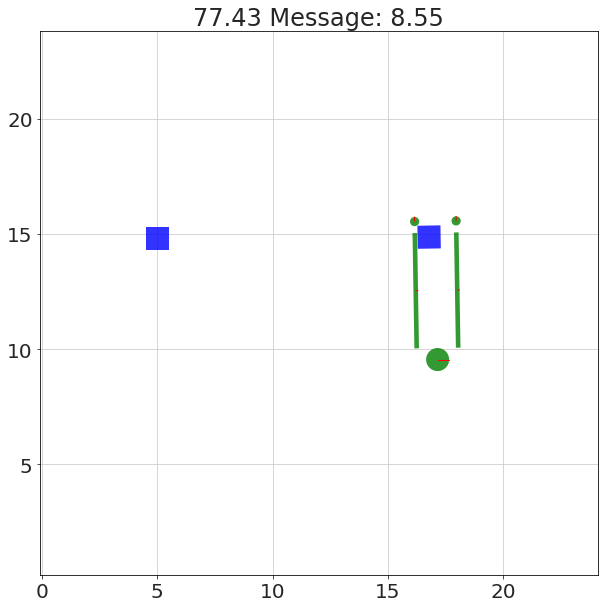

In [498]:
env=FrictionEnvironment(24,24)
robot=Robot(env)
build(robot) 
robot.monitor=monitor
robot.controller=Controller(state_machine)
robot.message='%.2f' % robot['right_disk'].read_distance()
rows = 4
columns = 7
for row in range(4):
    for column in range(7):
        if state[row,column] == 0:
            pass
        elif state[row,column]==1:
            Box(env,x=5+column*1.6,y=10 + (3-row)*1.6,density=0.0000001)
run_sim(env,robot.controller,
        total_time=80,  # seconds
        dt=1/60,
        dt_display= 3,  # make this larger for a faster display
       )

In [499]:
state=update_state(robot.state,1,robot.move)
show_state(state)

status=win_status(state,1)
if status=='win':
    print("The robot won")
elif status=='lose':
    print("The robot lost")    
elif status=='stalemate':
    print("stalemate")
else:
    pass
    
# human move

if not status:

    move=human_move(state,2)
    state=update_state(state,2,move)

    status=win_status(state,1)
    if status=='win':
        print("The human won")
    elif status=='lose':
        print("The human lost")    
    elif status=='stalemate':
        print("stalemate")
    else:
        pass

    show_state(state) 

 1  0  0  0  0  0  0 
 0  0  0  0  0  0  0 
 0  0  0  0  0  0  0 
 0  0  0  0  0  0  0 

Valid Moves: [0]


Select a move 0


The human lost
 0  0  0  0  0  0  0 
 0  0  0  0  0  0  0 
 0  0  0  0  0  0  0 
 0  0  0  0  0  0  0 

